<a href="https://colab.research.google.com/github/hdpark1208/StudyCode/blob/main/NLP/NLP_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attention

RNN 기반 seq2seq 모델의 한계  
1. 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고해서 정보 손실 발생  
2. RNN의 고질적인 문제인 기울기 손실(Vanishing Gradient) 문제 존재  

: 기계 번역 분야에서 입력 문장이 길어지면 품질이 떨어지는 현상

어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 보게 됩니다.

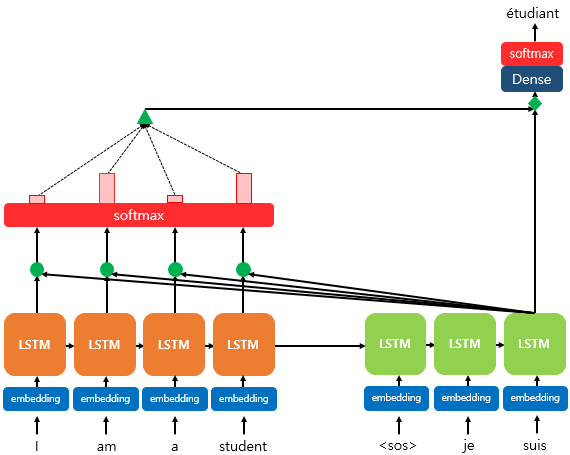

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/attention.png',width=700)

1) 어텐션 스코어(Attention Score)를 구한다  

2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다  

3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다  

4) 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)  

5) 출력층 연산의 입력이 되는 s^_t
를 계산합니다.  

6) s^_t
를 출력층의 입력으로 사용합니다


# Transformer

트랜스포머(Transformer)는 2017년 구글이 발표한 논문인 "Attention is all you need"에서 나온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)만으로 구현한 모델입니다. 이 모델은 RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 성능도 RNN보다 우수하다는 특징을 갖고있습니다

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 주요 하이퍼파라미터

d_model = 512
트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미합니다. 임베딩 벡터의 차원 또한 d_model
이며, 각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 차원을 유지합니다. 논문에서는 512입니다.

num_layers = 6
트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미합니다. 논문에서는 인코더와 디코더를 각각 총 6개 쌓았습니다.

num_heads = 8
트랜스포머에서는 어텐션을 사용할 때, 1번 하는 것 보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했습니다. 이때 이 병렬의 개수를 의미합니다.

d_ff = 2048
트랜스포머 내부에는 피드 포워드 신경망이 존재합니다. 이때 은닉층의 크기를 의미합니다. 피드 포워드 신경망의 입력층과 출력층의 크기는 d_model
입니다.

## 트렌스포머 구조

트랜스포머는 RNN을 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조를 유지하고 있습니다. 다만 다른 점은 인코더와 디코더라는 단위가 N개가 존재할 수 있다는 점입니다.

이전 seq2seq 구조에서는 인코더와 디코더에서 각각 하나의 RNN이 t개의 시점(time-step)을 가지는 구조였다면 이번에는 인코더와 디코더라는 단위가 N개로 구성되는 구조입니다. 트랜스포머를 제안한 논문에서는 인코더와 디코더의 개수를 각각 6개를 사용하였습니다.

## Positional Encoding

 RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점에 있었습니다.

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있습니다. 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 합니다.

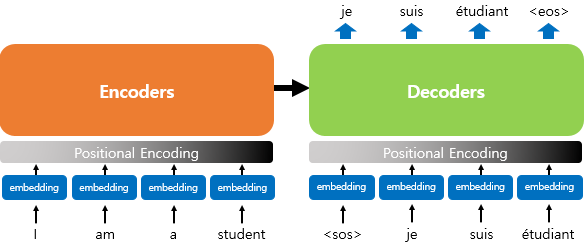

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/positionalEncoding.png',width=700)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


(1, 50, 128)


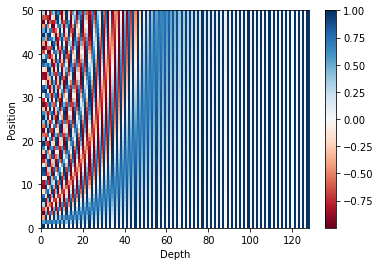

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Attention : 트랜스포머에서 사용되는 세 가지의 어텐션

(벡터의 출처에 대한 Query, Key, Value 관계)  
인코더의 셀프 어텐션 : Query = Key = Value  
디코더의 마스크드 셀프 어텐션 : Query = Key = Value  
디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터  

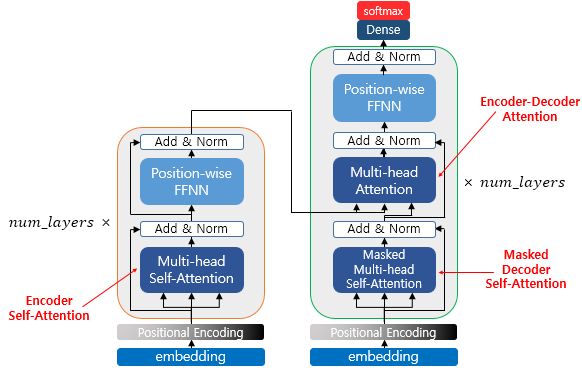

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/transformer_attention.png',width=700)


위 그림은 트랜스포머의 아키텍처에서 세 가지 어텐션이 각각 어디에서 이루어지는지를 보여줍니다. 세 개의 어텐션에 추가적으로 '멀티 헤드'라는 이름이 붙어있습니다. 이는 트랜스포머가 어텐션을 병렬적으로 수행하는 방법을 의미합니다.

## Encoder

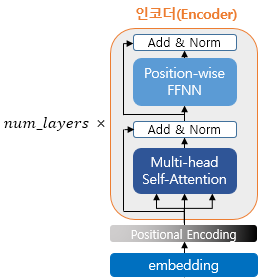

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/encoder.png',width=400)


어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줍니다. 그리고 유사도가 반영된 '값(Value)'을 모두 가중합하여 리턴합니다.

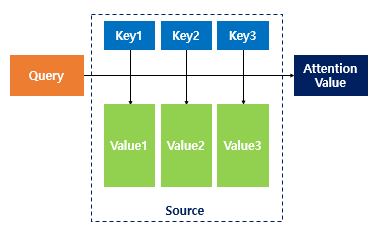

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/Query.png',width=400)


### 셀프 어텐션 : 어텐션을 자기 자신에게 수행한다  
Q : 입력 문장의 모든 단어 벡터들  
K : 입력 문장의 모든 단어 벡터들  
V : 입력 문장의 모든 단어 벡터들  

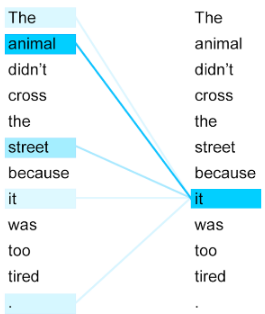

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/self.png',width=400)


위의 예시 문장을 번역하면 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.' 라는 의미가 됩니다. 그런데 여기서 그것(it)에 해당하는 것은 과연 길(street)일까요? 동물(animal)일까요? 우리는 피곤한 주체가 동물이라는 것을 아주 쉽게 알 수 있지만 기계는 그렇지 않습니다. 하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하므로서 그것(it)이 동물(animal)과 연관되었을 확률이 높다는 것을 찾아냅니다.

* 동작 메커니즘

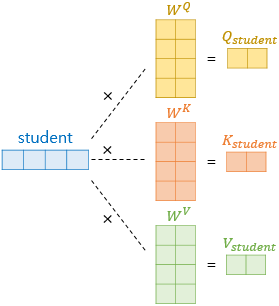

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/self2.png',width=400)


1. **Q,K,V 벡터 얻기**    
기존의 벡터로부터 더 작은 벡터는 가중치 행렬을 곱하므로서 완성됩니다. 각 가중치 행렬은 d_model X (d_model/num_heads)
의 크기를 가집니다. 이 가중치 행렬은 훈련 과정에서 학습됩니다. 즉, 논문과 같이 
d_model=512이고 num_heads=8라면, 각 벡터에 3개의 서로 다른 가중치 행렬을 곱하고 64의 크기를 가지는 Q, K, V 벡터를 얻어냅니다. 위의 그림은 단어 벡터 중 student 벡터로부터 Q, K, V 벡터를 얻어내는 모습을 보여줍니다. 모든 단어 벡터에 위와 같은 과정을 거치면 I, am, a, student는 각각의 Q, K, V 벡터를 얻습니다.

2. **Scaled dot-product Attention 수행**  
Q, K, V 벡터를 얻었다면 지금부터는 기존에 배운 어텐션 메커니즘과 동일합니다. 각 Q 벡터는 모든 K 벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V 벡터를 가중합하여 어텐션 값 또는 컨텍스트 벡터를 구하게 됩니다. 그리고 이를 모든 Q 벡터에 대해서 반복합니다.

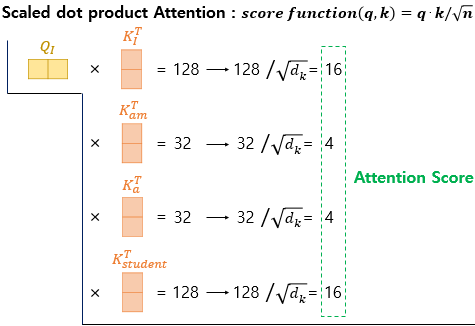

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/self3.png',width=600)

우선 단어 I에 대한 Q벡터를 기준으로 설명해보겠습니다. 지금부터 설명하는 과정은 am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 거칩니다. 위의 그림은 단어 I에 대한 Q 벡터가 모든 K 벡터에 대해서 어텐션 스코어를 구하는 것을 보여줍니다.

위의 그림에서 어텐션 스코어는 각각 단어 I가 단어 I, am, a, student와 얼마나 연관되어 있는지를 보여주는 수치입니다. 트랜스포머에서는 두 벡터의 내적값을 스케일링하는 값으로 K 벡터의 차원을 나타내는 d_k 
에 루트를 씌운 sqr(d_k)
 사용하는 것을 택했습니다. 앞서 언급하였듯이 논문에서 d_k
는 d_model/num_heads
라는 식에 따라서 64의 값을 가지므로 sqr(d_k)
는 8의 값을 가집니다

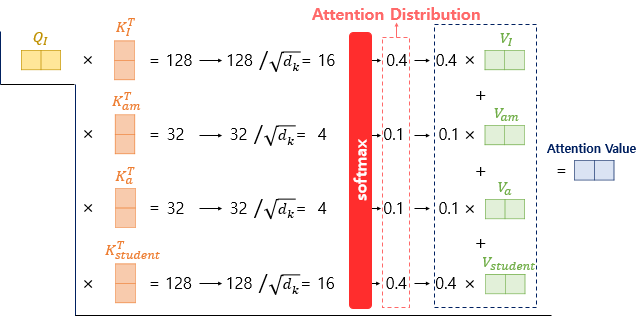

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/self4.png',width=600)


이제 어텐션 스코어에 소프트맥스 함수를 사용하여 어텐션 분포(Attention Distribution)을 구하고, 각 V 벡터와 가중합하여 어텐션 값(Attention Value)을 구합니다. 이를 단어 I에 대한 어텐션 값 또는 단어 I에 대한 컨텍스트 벡터(context vector)라고도 부릅니다. 이제 am에 대한 Q벡터, a에 대 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 반복하여 각각에 대한 어텐션 값을 구합니다.

굳이 이렇게 각 Q 벡터마다 일일히 따로 연산할 필요가 있을까요? 행렬 연산으로 일괄 처리!

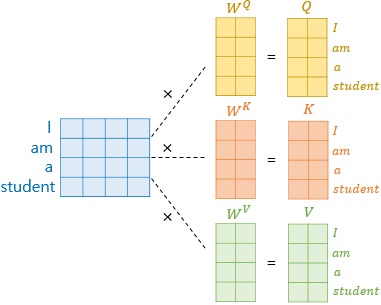

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/matrix.png',width=600)


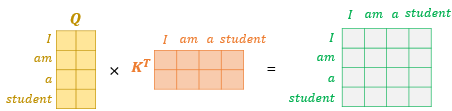

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/matrix2.png',width=600)

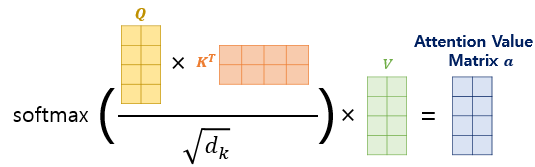

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/NLP/dataset/matrix3.png',width=600)

* Scaled dot-product Attention 구현

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9) # <PAD> 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [ ]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


* 멀티 헤드 어텐션 구현

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
-1e9

-1000000000.0